### AST 5731 
#### Group 3 - Project 3
#### Group Members: Thomas Atkins, Tyler Barna, Tore Boybei, and Haowen Zhong

##### Contents

 1. [Introduction](#introduction)
 2. [Data](#data)  
    2.1 [Importing Data](#importing-data)    
    2.2 [Data Visualization](#visualization)
 3. [Analysis](#analysis)   
    3.1 [Components of Statistical Model](#model)  
    3.2 [Prior Predictive Check](#prior)     
    3.3 [Posterior](#posterior)     
    3.4 [Sensitivity Analysis](#senstivity)  
    3.5 [Posterior Predictive Check](#ppc)   
 4. [Results](#results)

### 1. Introduction 
<a id='introduction'></a>

### 2. Data
<a id='data'></a>

Importing packages used for the project: 

In [9]:
import csv
import dis
import inspect
import os
import sys
import time

import astropy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
import arviz as az
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from IPython.display import display_html
from IPython.display import Image

from numpy import interp

from scipy import integrate
from scipy import linalg as la
from scipy import optimize

from scipy.stats import beta
from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import multivariate_normal as mvn
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from scipy.stats import uniform

from sklearn import preprocessing as pp
from sklearn.neighbors import KernelDensity

%matplotlib inline
plt.style.use("seaborn-colorblind")
mpl.rcParams.update({"axes.grid" : False})
plt.style.context(("seaborn-colorblind",))
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
## set seed for reproducibility
random.seed(5731)

#### 2.1 Importing Data
<a id='importing'></a>  

<font color='red'> TODO: data description </font>

Number of observations: 1447


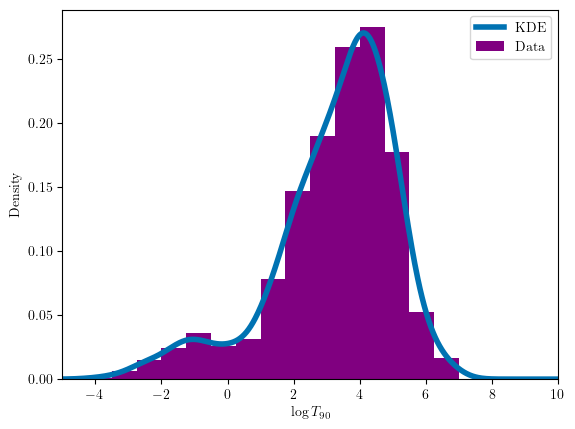

In [10]:
df = pd.read_csv("data.txt", sep="\t")
times = np.array(df['BAT T90 [sec]'].dropna())
data = []
for i in times:
  try:
    data.append(float(i))
  except:
    continue
times = np.array(data)
  
print(f"Number of observations: {len(times)}")

pd.DataFrame(np.log(times)).plot.kde( legend = False,linewidth = 4)
hist = plt.hist(np.log(times),range=[-5,10],density=True,bins=20,color= 'purple' )
plt.xlim([-5,10])
plt.xlabel(r'$\log T_{90}$')
plt.legend(['KDE','Data'])
plt.show()

### 3. Bayesian Analysis
<a id='analysis'></a>

#### 3.1 Components of Statistical Model
<a id='model'></a>

Our Gaussian mixture model is as follows. We assume that $X=\log(T_{90})$ arises as a result of a mixture of two Gaussian distributions.

$$
X | z_i = 0 \sim N(\mu_0, \tau_0) \\
X | z_i = 1 \sim N(\mu_1, \tau_1) \\
\mu_0, \mu_1 \sim N(\pm 1, 10) \\
\tau_0, \tau_1 \sim Gamma(1,1) \\
w\sim \text Dir(\alpha) \\
z_i|w_k \sim Cat(w)
$$

We choose $\alpha=$ for our Dirichlet prior. We choose -2 and 2 for the center of our mean priors to ensure that $\mu_0$ is always the lower mean.

##### Model Assumptions

Our model contains the following assumptions:

In [19]:
# Mixture of Normal and Normal variables
with pm.Model() as model:
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # 2 mixture weights

    mu1 = pm.Normal("mu1", -2, 10)
    mu2 = pm.Normal("mu2", 2, 10)

    tau1 = pm.Gamma('tau1', alpha=1, beta=1)
    tau2 = pm.Gamma('tau2', alpha=1, beta=1)

    components = [
        pm.Normal.dist(mu=mu1, tau=tau1),
        pm.Normal.dist(mu=mu2, tau=tau2)
    ]

    like = pm.Mixture('like', w=w, comp_dists=components, observed=np.log(times))
    idata = pm.sample_prior_predictive(samples=50)

Sampling: [like, mu1, mu2, tau1, tau2, w]


#### 3.2 Prior Predicitive Check
<a id='prior'></a>

#### 3.3 Posterior 
<a id='posterior'></a>

We sample from our model using the NUTS sampler.

In [20]:
with model:
      trace = pm.sample(draws=1000,return_inferencedata=True,
                        chains=4, cores=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [w, mu1, mu2, tau1, tau2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


We print the summary of the trace below.

In [23]:
summ = az.summary(trace)

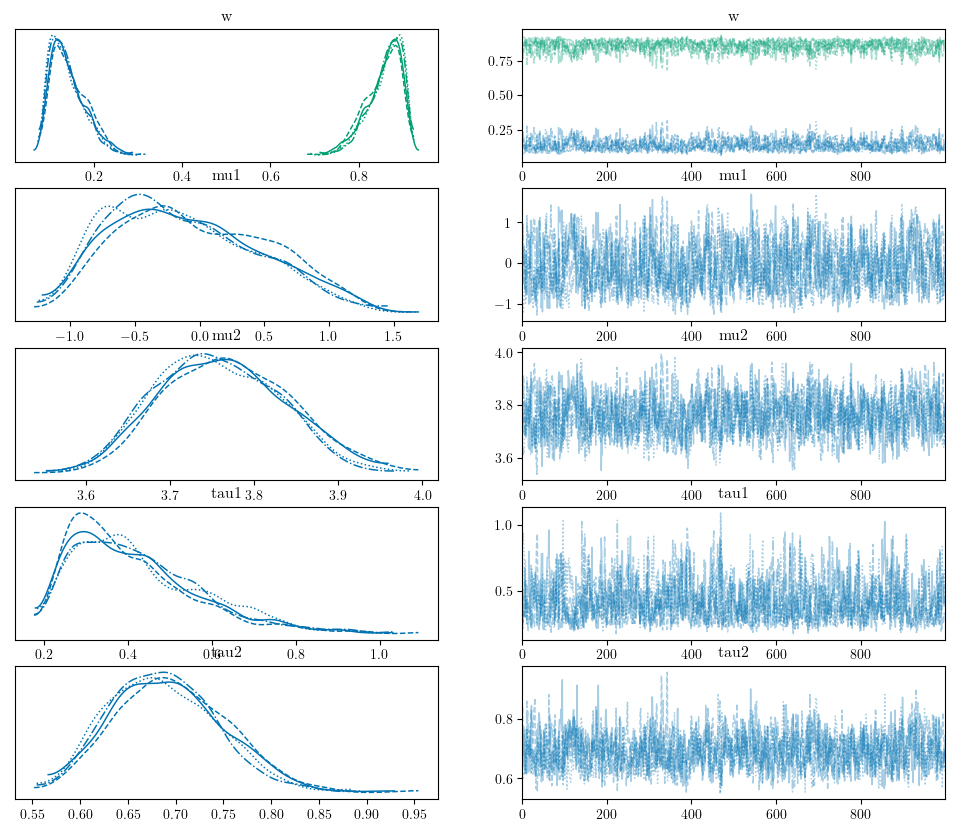

In [21]:
az.plot_trace(trace, var_names=["w", "mu1","mu2", "tau1", "tau2"]);

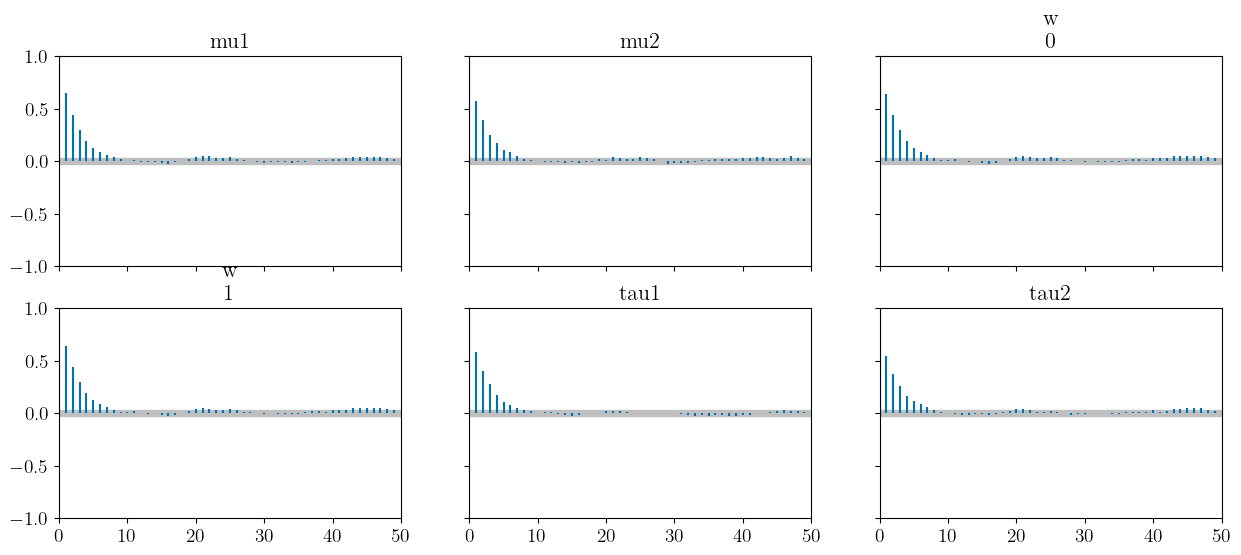

In [25]:
az.plot_autocorr(trace, var_names=['w', 'mu1', 'mu2', 'tau1', 'tau2'], filter_vars="like",  max_lag=50,combined=True,figsize=(15, 6));
plt.show()

In [37]:
for var in ['mu1', 'mu2', 'tau1', 'tau2']:
    print(f"{var} ESS: {float(az.ess(trace, method='mean')[var]):.2f}")
print(f"w0 ESS: {float(az.ess(trace, method='mean')['w'][0]):.2f}")
print(f"w1 ESS: {float(az.ess(trace, method='mean')['w'][1]):.2f}")

mu1 ESS: 831.07
mu2 ESS: 925.07
tau1 ESS: 902.95
tau2 ESS: 938.59
w0 ESS: 831.11
w1 ESS: 831.11


Our ESSs look reasonable, so we proceed. We now compute the distribution we are interested in, namely, the division between long and short GRBs. We do this by compuring the intersection of their gaussian curves using the quadratic formula.

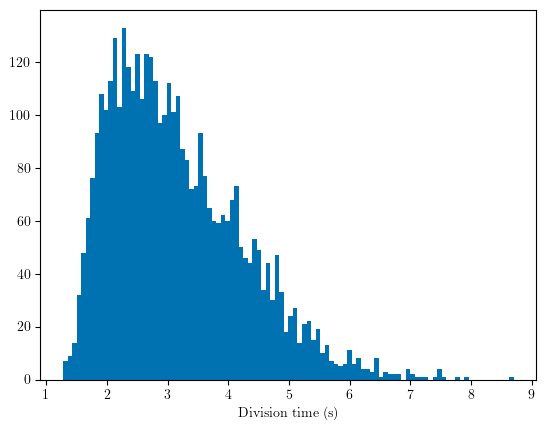

In [68]:
mu1 = np.reshape(np.array(trace.posterior.mu1), -1)
mu2 = np.reshape(np.array(trace.posterior.mu2), -1)
tau1 = np.reshape(np.array(trace.posterior.tau1), -1)
tau2 = np.reshape(np.array(trace.posterior.tau2), -1)
w = np.reshape(np.array(trace.posterior.w)[:, :, 0], -1)
var1 = 1/tau1
var2 = 1/tau2

# adapted from https://stats.stackexchange.com/questions/311592/how-to-find-the-point-where-two-normal-distributions-intersect
A = -tau1+tau2
B = 2*((-mu2/var2)+(mu1/var1))
C = mu2**2/var2-mu1**2/var1+np.log(var2/var1)+2*np.log(w/(1-w))

division = np.exp((-B - np.sqrt(B**2-4*A*C))/(2*A))

plt.hist(division, bins=100)
plt.xlabel("Division time (s)")
plt.show()

#### 3.4 Sensitivity Analysis
<a id='sensitivity'></a>

#### 3.4 Sensitivity Analysis
<a id='sensitivity'></a>

#### 3.4 Sensitivity Analysis
<a id='sensitivity'></a>

#### 3.5 Posterior Predictive Check
<a id='ppc'></a>

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, mu1, mu2, tau1, tau2]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 41 seconds.
Sampling: [like]


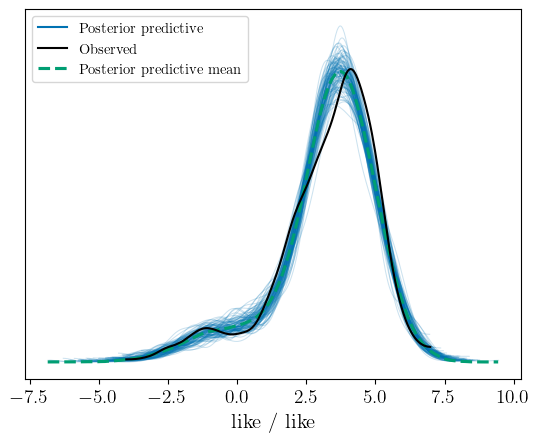

In [22]:
with model:
    idata.extend(pm.sample(1000, tune=2000))

with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

az.plot_ppc(idata, num_pp_samples=100);

### 4. Results
<a id='results'></a>